In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import epics as PV
import time
import math
from IPython.display import display, clear_output

In [2]:
class s19motor:
    def __init__(self, name, relRange = None, absRange = None, setPV = None, rbvPV = None, movPV = None):
        self.name = name
        if setPV is None:
            self.setPV = name+'.VAL'
        else:
            self.setPV = setPV
        if rbvPV is None:
            self.rbvPV = name+'.RBV'
        else:
            self.rbvPV = rbvPV
        if movPV is None:
            self.movPV = name+'.DMOV'
        else:
            self.movPV = movPV
        if relRange is None:
            self.scanStart = absRange[0]
            self.scanStop = absRange[1]
            self.scanStep = absRange[2]
        else: 
            self.scanStart = PV.caget(self.rbvPV)-relRange[0]
            self.scanStop = PV.caget(self.rbvPV)+relRange[0]
            self.scanStep = relRange[1]
        
        self.resetPosition = PV.caget(self.rbvPV)
        
    def reset(self):
        PV.caput(self.setPV, self.resetPosition)


### Define motors

Needs to be updated for s19BM

In [18]:
motors = [s19motor('tune', relRange = [100, 1.0], 
                   setPV = 'BM:MO:Atune:RqsPos', 
                   rbvPV = 'BM:MO:Atune:ActPos',
                   movPV = 'BM:MO:Atune:InPos'),
         s19motor('twist', relRange = [15, 1.0], 
                  setPV = 'BM:MO:Atwist:RqsPos', 
                  rbvPV = 'BM:MO:Atwist:ActPos',
                  movPV = 'BM:MO:Atwist:InPos'),
         s19motor('focus', relRange = [0.2, 0.002], 
                  setPV = 'BM:MO:Afocus:RqsPos', 
                  rbvPV = 'BM:MO:Afocus:ActPos',
                  movPV = 'BM:MO:Afocus:InPos')#,
#         s19motor('roll', relRange = [5.0, 0.5], 
#                  setPV = 'BM:MO:Achi:RqsPos', 
#                  rbvPV = 'BM:MO:Achi:ActPos',
#                  movPV = 'BM:MO:Achi:InPos')
         ]

In [19]:
hformat = "{:^10}|{:^10}|{:^10}|{:^10}|{:^10}|{:^15}|{:^15}"
oformat = "{0:^10}|{1:^10.3f}|{2:^10.3f}|{3:^10.3f}|{4:^10.4f}|{5:^15.3f}|{6:^15}"

print(hformat.format('Name','RBV','Start','Stop','Step','Reset Position','Status'))
print("-"*85)
for m in motors:
    print(oformat.format(m.name, PV.caget(m.rbvPV), m.scanStart, m.scanStop, m.scanStep
                         , m.resetPosition, PV.caget(m.movPV)))

   Name   |   RBV    |  Start   |   Stop   |   Step   |Reset Position |    Status     
-------------------------------------------------------------------------------------
   tune   | 1350.529 | 1250.529 | 1450.529 |  1.0000  |   1350.529    |       1       
  twist   | -57.781  | -72.781  | -42.781  |  1.0000  |    -57.781    |       1       
  focus   |  1.920   |  1.720   |  2.120   |  0.0020  |     1.920     |       1       


In [ ]:
#PV.caput(motors[0].setPV, 2.0)

In [62]:
def moveMotors(positions, eaMotors, seq = False):
    for pos, motor in zip(positions, eaMotors):
        PV.caput(motor.setPV, pos)    #moves done ~simultaneously, though started sequentially
        if seq:
            while stillMoving([motor]):
                time.sleep(0.05)
            

In [7]:
def getMotors(eaMotors):
    positions = []
    for motor in eaMotors:
        pos = PV.caget(motor.rbvPV)
        positions.append(pos)
    
    return np.asarray(positions)

### Define genes
Based on motors -- each entry in gene list contains an array of all possible values for that gene/motor

In [20]:
genes = [np.arange(motor.scanStart,motor.scanStop+motor.scanStep,motor.scanStep) for motor in motors]

In [21]:
for g in genes:
    print(g.shape)

(201,)
(31,)
(201,)


#### Test motor move

In [24]:
np.asarray([np.random.choice(gene) for gene in genes])

array([1439.52896467,  -59.78107467,    1.89998576])

In [64]:
moveMotors(np.asarray([np.random.choice(gene) for gene in genes]), motors, seq = True)

#### Set speed of all motors
Needs to be looked into further for s19

In [ ]:
#def setMotorV(gaMotors, speed):
#    speedPVs = ['.S', '.SBAK', '.SBAS']
#    for motor in gaMotors:
#        [PV.caput(motor.pvName+sPV,speed) for sPV in speedPVs]

In [ ]:
#setMotorV(motors, speed = 0.1)

#### Check if motors are still moving

In [10]:
def stillMoving(eaMotors):
    # 0 = moving
    # 1 = positioned
    status = [bool(PV.caget(motor.movPV)) for motor in eaMotors]
    
    moving = not all(status)
    
    return moving
    

In [11]:
stillMoving(motors)

False

In [65]:
moveMotors(np.asarray([np.random.choice(gene) for gene in genes]), motors)
time.sleep(0.05)
while stillMoving(motors):
    print("Still Moving \r", end = '')
#    print("Still Moving", [PV.caget(m.movPV) for m in motors])
print("Done Moving ")
for m in motors:
    print(m.name, PV.caget(m.movPV))

Done Moving  
tune 1
twist 1
focus 1


### Initialize population

In [27]:
def init_pop(nPopulation, genes, seed = 42):
    population = []
    np.random.seed(seed)
    for i in range(nPopulation):
        population.append(np.asarray([np.random.choice(gene) for gene in genes]))
        
    return population

### Fitness function
Needs to be updated for s19BM

In [99]:
downStreamPV = 'BM:M:DNBPM:SumSR'
guardSlitPV = 'BM:M:GSBPM:SumSR'

def fitness(GS = False, wait = 0.5):

    if GS:
        diagPV = guardSlitPV
    else:
        diagPV = downStreamPV
    time.sleep(wait)
    fit = PV.caget(diagPV)
    
    return fit

In [66]:
print(fitness())

2.30763197498002e-08


In [67]:
print(fitness(GS=True))

1.4321876240851376e-08


In [100]:
def get_fitness(pop, motors, GS = False, OM = False, minFit = 0, wTime = 0.5, seq = True, dTime = 0.25):
    fitnessArr = []
    act_popN = 0
    oldFit = -1
    for j, p in enumerate(pop):
        if OM:
            tempFit = minFit
            rePop = False
        moveMotors(p, motors, seq = seq)
        time.sleep(wTime)
        while stillMoving(motors):          
            if OM:
                currP = getMotors(motors)
                currFit = fitness(GS = GS, wait = dTime)
                if oldFit != tempFit:
                    act_popN += 1
                    oldFit = tempFit
                if currFit > tempFit:
                    tempP = currP
                    tempFit = currFit
                    rePop = True
                    
        finalFit = fitness(GS = GS)
        if OM and rePop:
            if tempFit > finalFit:
                finalFit = tempFit
                pop[j] = tempP
        fitnessArr.append(finalFit)

    return pop, fitnessArr, act_popN

### Test fitness function for population

In [101]:
testPop = init_pop(10, genes)
print('Initial Population:')
for p in testPop:
    print(p)
_, testFitness, _ = get_fitness(testPop, motors, OM = False)
print('test Fitness')
print(testFitness)

Initial Population:
[1352.52896467  -53.78107467    1.90398576]
[1264.52896467  -62.78107467    1.86198576]
[1438.52896467  -52.78107467    1.92398576]
[1371.52896467  -54.78107467    1.86798576]
[1337.52896467  -52.78107467    1.91798576]
[1353.52896467  -49.78107467    1.97998576]
[1399.52896467  -52.78107467    1.72198576]
[1337.52896467  -61.78107467    2.03398576]
[1287.52896467  -71.78107467    2.10198576]
[1437.52896467  -52.78107467    2.03998576]
test Fitness
[3.769130928559833e-07, 1.9606975520779523e-08, 2.7205951040596234e-08, 1.9346686726255413e-08, 2.031367536075121e-07, 5.897908011504696e-07, 3.6877375327567746e-07, 2.779288270925105e-07, 2.0684704528804652e-08, 1.6477859397586777e-07]


In [81]:
moveMotors(np.asarray([m.resetPosition for m in motors]), motors, seq = True)

[1350.528964674479, -57.781074674479214, 1.919985758]

### Test fitness function for population with Observer mode

not using observer mode for s19 initially

In [ ]:
newPop, newFitness, _ = get_fitness(testPop, motors, OM = True)
print('New Population:')
for p in newPop:
    print(p)
print('New Fitness:')
print(newFitness)

### Ranking by fitness

In [102]:
def rank_pop(fitness):
    return np.argsort(fitness)

### Select Mating Pool

In [103]:
def mating_pool_probs(fitness):
    return [fit/sum(fitness) for fit in fitness]

In [104]:
def get_mating_pool(population, rankings, probs, nElites, nPopulation):
    rankedProbs = [probs[i] for i in rankings]
    
    #include elites
    #remainder based on probabilities from fitness_i/sum(fitness_i)
    breedingPop = []
    breedingPop[0:nElites] = rankings[::-1][0:nElites]
    breedingPop[nElites:nPopulation-nElites] = np.random.choice(rankings, size = nPopulation-nElites, p = rankedProbs)
    
    return breedingPop

### Breed (crossover)

In [105]:
def get_offspring(nGenes, nPopulation, population, breedingPop, Pc):
    #iterate through pairs i, i+1 (N/2 times) and if P < Pc swap genes 1 through randomly choose of 2,..,N-1)
    offspring = []
    for i in range(int(nPopulation/2)):
        parent1 = np.copy(population[breedingPop[2*i]])
        parent2 = np.copy(population[breedingPop[2*i+1]])
        
        child1 = np.copy(parent1)
        child2 = np.copy(parent2)
        if np.random.random() < Pc:
            crossover = np.random.choice(nGenes-1) + 1
            child1[crossover:]=parent2[crossover:]
            child2[crossover:]=parent1[crossover:]
        offspring.append(child1)
        offspring.append(child2)
    return offspring

### Mutate

In [106]:
def mutate_pop(pop, Pm, genes):
    #iterate through all genes on all chromosomes, if P < Pm pick randomly from gene's interval
    mutatedOffspring = np.copy(pop)
    for i, ind in enumerate(pop):
        for j, gene in enumerate(ind):
            if np.random.random() < Pm:
                mutatedOffspring[i][j] = np.random.choice(genes[j])
            
    
    return mutatedOffspring

### Put together

In [107]:
def gaScan(motors, nPopulation = 10, Pc = 0.8, Pm = 0.05, nGenerations = 100, nElite = 5
           , OM = True, critVal = 1.0, seed = 42):
    print('Observer Mode: {}'.format(OM))
    startTime = time.time()
    genes = [np.arange(motor.scanStart,motor.scanStop+motor.scanStep,motor.scanStep) for motor in motors]
    nGenes = len(genes)
    pop = init_pop(nPopulation, genes, seed)
    peakFit = []
    aveFit = []
    
    fig = plt.figure(figsize = (8,5))
    ax = fig.add_subplot(1, 1, 1) 
    #ax = fig.add_subplot(2, 1, 1) 
    #bx = fig.add_subplot(2, 1, 2)
    
    sampledN = 0
    
    #for i in log_progress(range(nGenerations), name = "Generations"):
    for i in range(nGenerations):
        pop, popFitness, popN = get_fitness(pop, motors, OM = (OM and (i > 0)))
        peakFit.append(max(popFitness))
        aveFit.append(np.mean(popFitness))
        
        sampledN += popN
        
        if peakFit[-1] < critVal:
            print('Current Peak Fitness: {}; Goal Value: {} \r'.format(peakFit[-1], critVal), end = '')
            rankings = rank_pop(popFitness) # list of indexes
            probs = mating_pool_probs(popFitness)
        
            breedingPop = get_mating_pool(pop, rankings, probs, nElite, nPopulation)
            offspring = get_offspring(nGenes, nPopulation, pop, breedingPop, Pc)
            pop = mutate_pop(offspring, Pm, genes)
        else:
            print('Final Peak Fitness: {}'.format(peakFit[-1]))
            print('Minimum fitness criteria met')
            moveMotors(pop[np.argmax(popFitness)], motors, seq = True)
    
        
        ax.cla()
        
        line1, = ax.plot(peakFit, color = 'r', label = 'Peak Fitness')
        line2, = ax.plot(aveFit, color = 'b', label = 'Ave Fitness')
        ax.legend(loc='lower right')
        ax.set_title('Population = {}, Elites = {}, Pc = {}, Pm = {}, OM = {}'.format(nPopulation, 
                                                                                      nElites, Pc, Pm, OM))
        ax.set_xlabel('Generation')
        ax.set_ylabel('Fitness')
        ax.set_ylim([0,1.1*critVal])
        
        display(fig)
        clear_output(wait = True)
    
        if peakFit[-1] >= critVal:
            break
            
    print(' ')
#    pop, finalFitness = get_fitness(pop, motors, OM = False)
#    peakFit.append(max(finalFitness))
#    aveFit.append(np.mean(finalFitness))

#    ax.cla()
        
#    line1, = ax.plot(peakFit, color = 'r', label = 'Peak Fitness')
#    line2, = ax.plot(aveFit, color = 'b', label = 'Ave Fitness')
#    ax.legend(loc='lower right')
#    ax.set_title('Population = {}, Elites = {}, Pc = {}, Pm = {}, OM = {}'.format(nPopulation, 
#                                                                                     nElites, Pc, Pm, OM))
#    ax.set_xlabel('Generation')
#    ax.set_ylabel('Fitness')
#    ax.set_ylim([0,1.0])
    
#    display(fig)
#    clear_output(wait = True)
    
    endTime = time.time()
    print('Total processing time {} s'.format(math.floor(endTime-startTime)))
    
#    fig, ax = plt.subplots()
#    line1, = ax.plot(peakFit, color = 'r', label = 'Peak Fitness')
#    line2, = ax.plot(aveFit, color = 'b', label = 'Ave Fitness')
#    ax.legend(loc='lower right')
#    ax.set_title('Population = {}, Elites = {}, Pc = {}, Pm = {}, OM = {}'.format(nPopulation, nElites, 
#                                                                                  Pc, Pm, OM))
#    ax.set_xlabel('Generation')
#    ax.set_ylabel('Fitness')
#    plt.show
    
    return aveFit, peakFit, sampledN
          
    
    

In [111]:
moveMotors(np.asarray([m.resetPosition for m in motors]), motors, seq = True)

 
Total processing time 162 s


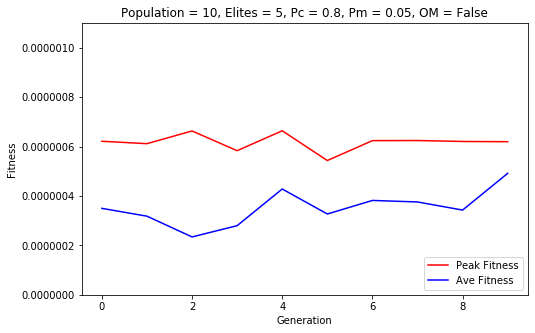

In [109]:
seed = 42
nPop = 10
Pc = 0.8
Pm = 0.05
nElites = 5
nGen = 10
#setMotorV(motors, speed = 2.0)

aveFit, peakFit, sampledN = gaScan(motors, nPopulation = nPop, Pc = Pc, Pm = Pm, nGenerations = nGen
                                   , nElite = nElites, OM = False, critVal = 1e-6, seed = seed)



In [110]:
peakFit[-1]

6.196223515096567e-07

In [94]:
peakFit[-1]

6.327439949555645e-07

In [ ]:
peakFit[-1]